<a href="https://colab.research.google.com/github/ilmaaliyaf/graph-partition-dimension/blob/main/Graph_Partition_Dimension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jalankan 3 cell di bawah untuk menyiapkan class dan functions

In [2]:
#@title Import modules
import networkx as nx
import numpy as np
from timeit import default_timer as timer
import pandas as pd
import matplotlib.pyplot as plt
import sys
import copy
from itertools import combinations

In [3]:
#@title Partition of a set-search function (Knuth in the Art of Computer Programming, Volume 4, Fascicle 3B, exercise 17 in section 7.2.1.5)
def partition(Set, m):
    ''' function to create all possible partitions of a set '''
    def visit(n, a):
        ps = [[] for i in range(m)]
        for j in range(n):
            ps[a[j + 1]].append(Set[j])
        return ps

    def f(mu, nu, sigma, n, a):
        if mu == 2:
            yield visit(n, a)
        else:
            for v in f(mu - 1, nu - 1, (mu + sigma) % 2, n, a):
                yield v
        if nu == mu + 1:
            a[mu] = mu - 1
            yield visit(n, a)
            while a[nu] > 0:
                a[nu] -= 1
                yield visit(n, a)
        elif nu > mu + 1:
            if (mu + sigma) % 2 == 1:
                a[nu - 1] = mu - 1
            else:
                a[mu] = mu - 1
            if (a[nu] + sigma) % 2 == 1:
                for v in b(mu, nu - 1, 0, n, a):
                    yield v
            else:
                for v in f(mu, nu - 1, 0, n, a):
                    yield v
            while a[nu] > 0:
                a[nu] -= 1
                if (a[nu] + sigma) % 2 == 1:
                    for v in b(mu, nu - 1, 0, n, a):
                        yield v
                else:
                    for v in f(mu, nu - 1, 0, n, a):
                        yield v

    def b(mu, nu, sigma, n, a):
        if nu == mu + 1:
            while a[nu] < mu - 1:
                yield visit(n, a)
                a[nu] += 1
            yield visit(n, a)
            a[mu] = 0
        elif nu > mu + 1:
            if (a[nu] + sigma) % 2 == 1:
                for v in f(mu, nu - 1, 0, n, a):
                    yield v
            else:
                for v in b(mu, nu - 1, 0, n, a):
                    yield v
            while a[nu] < mu - 1:
                a[nu] += 1
                if (a[nu] + sigma) % 2 == 1:
                    for v in f(mu, nu - 1, 0, n, a):
                        yield v
                else:
                    for v in b(mu, nu - 1, 0, n, a):
                        yield v
            if (mu + sigma) % 2 == 1:
                a[nu - 1] = 0
            else:
                a[mu] = 0
        if mu == 2:
            yield visit(n, a)
        else:
            for v in b(mu - 1, nu - 1, (mu + sigma) % 2, n, a):
                yield v

    n = len(Set)
    a = [0] * (n + 1)
    for j in range(1, m + 1):
        a[n - m + j] = j - 1
    return f(m, n, 0, n, a)

In [38]:
#@title Graph class and functions

class Graph(nx.graph.Graph):
    def __init__(self, graph_type='', parameter=[]):
        if graph_type not in ['path', 'cycle', 'complete', 'complete_bipartite']:
            self.graph = nx.empty_graph()
            self.graph_params = None
        else:    
            self.define_type(graph_type, parameter)
        
        self.distance = self.distance_()
        self.basis = None
        self.pd = None
        self.count = 0

    def define_type(self, graph_type, parameter):
        self.graph_type = graph_type
        self.graph_params = parameter
        if graph_type not in ['path', 'cycle', 'complete', 'complete_bipartite']:
            raise ("Choose type between path, cycle, complete, and complete_bipartite")
        else:
            self.graph = eval('nx.' + graph_type + '_graph(*parameter)')
            
    def diam(self):
        return nx.diameter(self.graph)
    
    def distance_(self):
        a = dict(nx.all_pairs_shortest_path_length(self.graph))
        self.distance = a
        return a

    def find_pd(self,  
           num_basis=1, 
           lower_bound=2, 
           upper_bound='',
           print_result = False):
        ''' find basis for this graph '''
        V = list(self.graph)
        basis_dict = {}
        if type(upper_bound) != int:
            upper_bound = self.graph.order()+1

        i = 0
        # self.count = 0
        # print('count: ', self.count)
        for k in range(lower_bound, upper_bound):
            partitions = partition(V, k)
            for j, P in enumerate(partitions):
                if j < self.count:
                    # print('.', end='')
                    # print(j)
                    continue
                # print('!', end='')
                resolving, representation = self.is_resolving(P)
                if resolving: # add P into basis_dict
                    basis_dict[i] = {'p': P, 'r': representation}
                    self.basis = basis_dict
                    self.pd = len(basis_dict[0]['p'])
                    i += 1
                    # out = f'{i}/{num_basis}'
                    # sys.stdout.write("\r"+out)
                    if print_result:
                        print(P)
                    if i + 1 > num_basis:
                        self.count = j
                        return
    
    def is_resolving(self, partition):
        r = {}
        d = self.distance
        for v in self.graph.nodes:
            r[v] = []
            for P in partition:
                dvP = d[v][min(P, key=d[v].get)]
                r[v].append(dvP)
        r_reversed = {str(val):key for key,val in r.items()}
        return len(r) == len(r_reversed), r

    def r(self, partition):
        r = {}
        d = self.distance
        for v in self.graph.nodes:
            r[v] = []
            for P in partition:
                dvP = d[v][min(P, key=d[v].get)]
                r[v].append(dvP)
        return r


    def draw(self, partition=[[]], num_figure=0, label_on=True, edge_on=True, 
             grid_layout=True, nodesize = 300, show_not_resolved=True):
        colors = ('purple','r','g','yellow','c','m','orange','lime','lightblue',
                'pink','coral','teal','silver','slategray','darkkhaki',
                'maroon', 'b','royalblue','olive','gold')
        graph = self.graph
        V = graph.nodes
        
        layout, layout_label = {}, {}

        if grid_layout and self.graph_type == 'product':
            for v in V:
                layout[v] = np.array([v[0], v[1]])
                layout_label[v] = np.array([v[0], v[1]])
        else:
            layout = nx.spring_layout(graph)
            layout_label = layout
        
        if partition != [[]]:
            representation = self.r(partition)
            
            # check if there are any not-resolved nodes
            not_resolved_node = []
            for v in representation:
                for u in representation:
                    if u != v :
                        if representation[u] == representation[v]:
                            if v not in not_resolved_node:
                                not_resolved_node.append(v)

        if self.graph_type == 'product':
            x = list(self.graph.nodes())[-1][0] * 1.2
            y = list(self.graph.nodes())[-1][1] * 2
            plt.figure(figsize=(x,y))

        # draw the nodes
        nx.draw_networkx_nodes(graph, layout, node_size = nodesize)

        if edge_on: # draw the edge
            nx.draw_networkx_edges(graph, layout)
        
        # draw the colored partition
        for i in range(len(partition)):
            nx.draw_networkx_nodes(graph, layout, #ax = ax[num_figure-1],
                                   nodelist = partition[i],
                                   node_size = nodesize,
                                   node_color = colors[i]
                                   )
            
        # draw the not-resolved nodes with black color
        if show_not_resolved and partition != [[]]:
            nx.draw_networkx_nodes(graph, layout, 
                                nodelist=not_resolved_node, 
                                node_color="white")
        
        if label_on and partition != [[]]: # draw the label
            nx.draw_networkx_labels(graph, layout_label, 
                                    labels=representation, 
                                    font_size=6,
#                                     font_weight='heavy'
                                    # bbox=dict(facecolor='red', alpha=0.5)
                                    )
            
        plt.axis('off')
        plt.margins(x=0.1, y=0.1)
        # plt.subplots_adjust(buttom=0.2)
            
    def power(self, k):
        d = self.distance_()
        nodes = list(self.graph.nodes)
        for i in range(len(nodes)):
            for j in range(i,len(nodes)):
                if d[nodes[i]][nodes[j]] == k:
                    self.graph.add_edge(nodes[i], nodes[j])
        if k == 2:
            K = f'{k}nd'
        elif k == 3:
            K = f'{k}rd'
        elif k > 3:
            K = f'{k}th'
        self.graph_type = f'{K} power of {self.graph_type}'
        return self


class productGraph(Graph):
    def __init__(self, graphs, product_type, product_params):
        self.initial_graph = graphs
        self.product_type = product_type
        self.product_params = product_params
        self.graph_type = 'product'

        if product_type == 'k-strong':
            self.k_strong()
        else:
            self.graph = nx.empty_graph()
            
        self.count = 0
        
        self.distance = self.distance_()

    def k_strong(self):
        G = self.initial_graph[0]
        H = self.initial_graph[1]
        if self.product_params == 1:
            self.graph = nx.strong_product(G.graph, H.graph)
        else:
            P = nx.cartesian_product(G.graph, H.graph)
            dG = G.distance
            dH = H.distance
            jumping_vertex = []
            for u in P.nodes:
                for v in P.nodes:
                    if dG[u[0]][v[0]] == self.product_params \
                    and dH[u[1]][v[1]] == self.product_params:
                        P.add_edge(u,v)
                        if v not in jumping_vertex:
                            jumping_vertex.append(v)
            self.graph = P
            self.jumping_vertex = jumping_vertex
            


def partition(Set, m):
    ''' function to create all possible partitions of a set '''
    def visit(n, a):
        ps = [[] for i in range(m)]
        for j in range(n):
            ps[a[j + 1]].append(Set[j])
        return ps

    def f(mu, nu, sigma, n, a):
        if mu == 2:
            yield visit(n, a)
        else:
            for v in f(mu - 1, nu - 1, (mu + sigma) % 2, n, a):
                yield v
        if nu == mu + 1:
            a[mu] = mu - 1
            yield visit(n, a)
            while a[nu] > 0:
                a[nu] -= 1
                yield visit(n, a)
        elif nu > mu + 1:
            if (mu + sigma) % 2 == 1:
                a[nu - 1] = mu - 1
            else:
                a[mu] = mu - 1
            if (a[nu] + sigma) % 2 == 1:
                for v in b(mu, nu - 1, 0, n, a):
                    yield v
            else:
                for v in f(mu, nu - 1, 0, n, a):
                    yield v
            while a[nu] > 0:
                a[nu] -= 1
                if (a[nu] + sigma) % 2 == 1:
                    for v in b(mu, nu - 1, 0, n, a):
                        yield v
                else:
                    for v in f(mu, nu - 1, 0, n, a):
                        yield v

    def b(mu, nu, sigma, n, a):
        if nu == mu + 1:
            while a[nu] < mu - 1:
                yield visit(n, a)
                a[nu] += 1
            yield visit(n, a)
            a[mu] = 0
        elif nu > mu + 1:
            if (a[nu] + sigma) % 2 == 1:
                for v in f(mu, nu - 1, 0, n, a):
                    yield v
            else:
                for v in b(mu, nu - 1, 0, n, a):
                    yield v
            while a[nu] < mu - 1:
                a[nu] += 1
                if (a[nu] + sigma) % 2 == 1:
                    for v in f(mu, nu - 1, 0, n, a):
                        yield v
                else:
                    for v in b(mu, nu - 1, 0, n, a):
                        yield v
            if (mu + sigma) % 2 == 1:
                a[nu - 1] = 0
            else:
                a[mu] = 0
        if mu == 2:
            yield visit(n, a)
        else:
            for v in b(mu - 1, nu - 1, (mu + sigma) % 2, n, a):
                yield v

    n = len(Set)
    a = [0] * (n + 1)
    for j in range(1, m + 1):
        a[n - m + j] = j - 1
    return f(m, n, 0, n, a)

# Usage

Himpunan titik di graf g	: [0, 1, 2, 3]
Himpunan sisi di graf g 	: [(0, 1), (1, 2), (2, 3)]


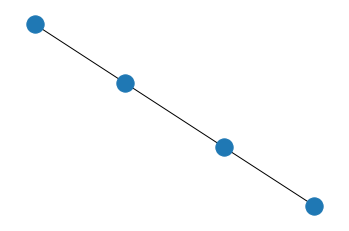

In [35]:
g = Graph('path',[4]) # create 4-path graph
h = Graph('cycle',[5]) # create 5-cycle graph
p = Graph('complete_bipartite',[2, 3]) # create 2,3-complete bipartite graph

print('Himpunan titik di graf g\t:', g.graph.nodes())
print('Himpunan sisi di graf g \t:', g.graph.edges())
g.draw([[]]) # draw g without any partition

Orde graf h	: 5
Diameter graf h	: 2


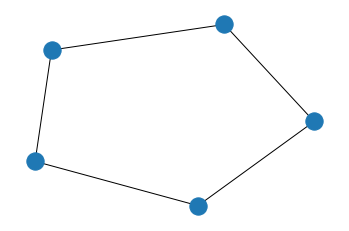

In [20]:
print('Orde graf h\t:', h.graph.order())
print('Diameter graf h\t:', h.diam())
h.draw([[]]) # draw g without any partition

Dimensi partisi graf p : 3
Partisi basis1 untuk p	: [[0, 3], [1, 2], [4]]
Representasi p terhadap basis1 	: {0: [0, 1, 1], 1: [1, 0, 1], 2: [1, 0, 2], 3: [0, 1, 2], 4: [1, 1, 0]}


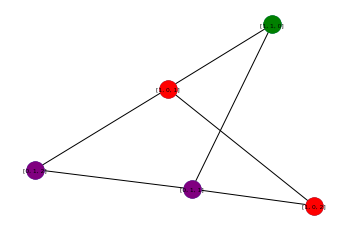


Partisi basis1 untuk p	: [[0, 3], [1, 4], [2]]
Representasi p terhadap basis1 	: {0: [0, 1, 1], 1: [1, 0, 1], 2: [1, 1, 0], 3: [0, 1, 2], 4: [1, 0, 2]}


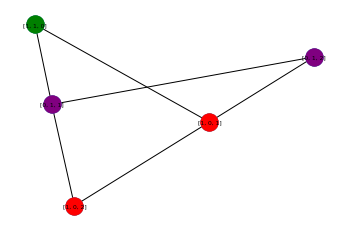

In [52]:
p.find_pd(num_basis=2,
          lower_bound=2,
          print_result=False)

basis1 = p.basis[0]
basis2 = p.basis[1]

print('Dimensi partisi graf p :', p.pd)

print('Partisi basis1 untuk p\t:', basis1['p'])
print('Representasi p terhadap basis1 \t:', basis1['r'])
p.draw(basis1['p'])

plt.show()
print()

print('Partisi basis1 untuk p\t:', basis2['p'])
print('Representasi p terhadap basis1 \t:', basis2['r'])
p.draw(basis2['p'])

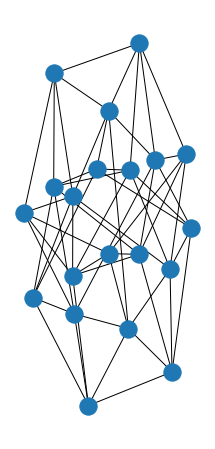

In [41]:
product = productGraph((g, h), 'k-strong', 2)
product.draw([[]], grid_layout=False)

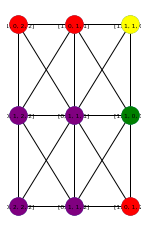

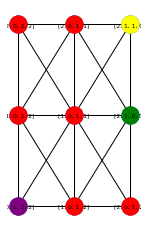

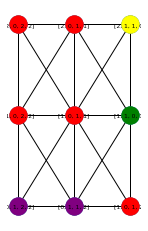

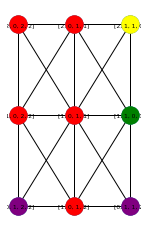

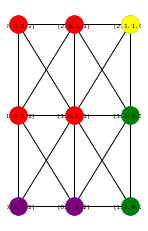

In [57]:
%matplotlib inline
g = Graph('path', [3])
product = productGraph((g, g), 'k-strong', 1)
product.find_pd(num_basis=5)

for i in range(5):
    product.draw(product.basis[i]['p'])
    plt.show

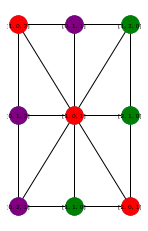

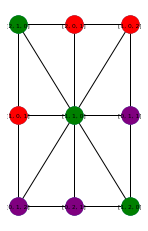

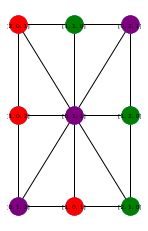

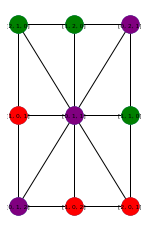

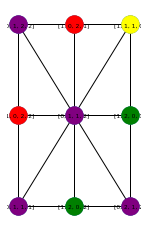

In [51]:
%matplotlib inline
g = Graph('path', [3])
product = productGraph((g, g), 'k-strong', 2)
product.find_pd(num_basis=5)

for i in range(5):
    product.draw(product.basis[i]['p'])
    plt.show